In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy as sc
import random 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols

In [2]:
df = pd.read_csv('C:/Users/chira/Documents/Data/four_sessions.csv')

Text(0, 0.5, 'Time in (Sec)')

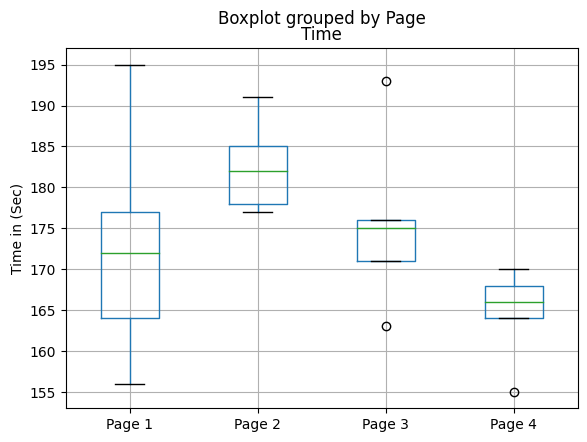

In [4]:
ax = df.boxplot(by='Page',column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time in (Sec)')

In [3]:
df.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In [47]:
mean_a = df[df.Page == 'Page 1'].Time.mean()
mean_b = df[df.Page == 'Page 2'].Time.mean()
print("Mean session Time Page A: ",mean_a)
print("Mean session Time Page B: ",mean_b)

Mean session Time Page A:  172.8
Mean session Time Page B:  182.6


In [5]:
def permutation_test(x,nA,nB):
    n = nA + nB
    idx_B = set(random.sample(range(n),nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

In [4]:
perm_dif = [permutation_test(df.Time,15,5) for _ in range(1000)]

Text(0, 0.5, 'Frequency')

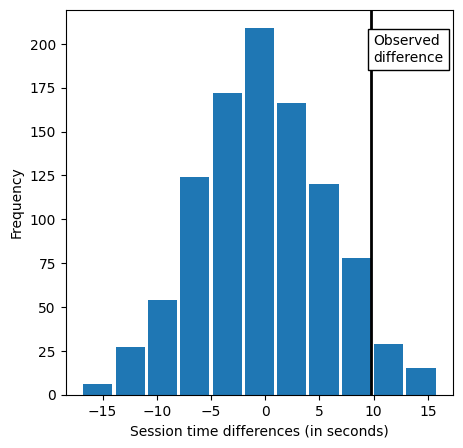

In [7]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_dif,bins=11,rwidth=.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)
ax.text(10, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')


In [58]:
print("Only",np.mean(perm_dif > (mean_b - mean_a))*100,"%","of the time resampled value is greater than Observed value")
print('Hence this has no statistical significance')

Only 5.7 % of the time resampled value is greater than Observed value
Hence this has no statistical significance


#Statistical significance and p-value

In [10]:
observed_dif  = 100 * (200/(23539+200) - 182/(182+22406))
print('Oberserved Differece', observed_dif,'%')

Oberserved Differece 0.03675791182059275 %


In [12]:
# creating a chance scenario
convertion = [0]*45945
convertion.extend([1]*382)
convertion = pd.Series(convertion)
convertion.value_counts()

0    45945
1      382
dtype: int64

In [27]:
conversion_diff = [100 * permutation_test(convertion,23739,22588) for _ in range(1000)]

Text(0.5, 0, 'Conversion Rate')

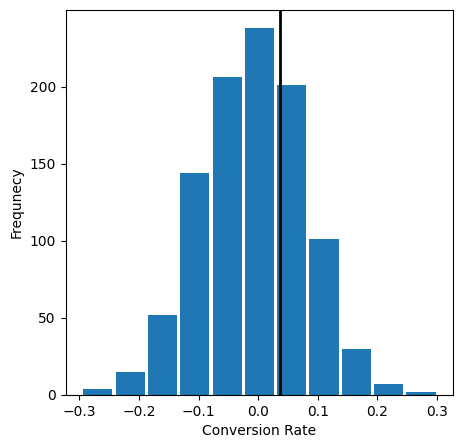

In [28]:
fig,ax = plt.subplots(figsize=(5,5))
ax.hist(conversion_diff,bins=11,rwidth=.9)
ax.axvline(x=observed_dif,color='black',lw=2)
ax.set_ylabel('Frequnecy')
ax.set_xlabel('Conversion Rate')

In [31]:
np.mean(pd.Series(conversion_diff).gt(observed_dif))*100

30.5

In [33]:
#normal Approximation
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2,p_value,df,_ = sc.stats.chi2_contingency(survivors)

In [48]:
a = df[df.Page == 'Page 1'].Time
b = df[df.Page == 'Page 2'].Time

In [37]:
print(f'p-value for single sided test: {p_value/2:.4f}')

p-value for single sided test: 0.3498


In [49]:
res = sc.stats.ttest_ind(df[df['Page'] == 'Page 1'].Time,df[df['Page'] == 'Page 2'].Time,equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1113


#ANOVA


In [8]:
#ANOVA
observed_variance = df.groupby('Page').mean().var()[0]
observed_variance

55.426666666666655

In [11]:
print('Observed means:', df.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655


In [12]:
def anova_perm_test(df):
    df = df.copy()
    df.Time = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]

In [17]:
perm_variance = [anova_perm_test(df) for _ in range(3000)]
print('pr(Prob)',np.mean([perm_variance > observed_variance])*100)

pr(Prob) 7.466666666666668


In [37]:
model  = ols('Time ~ Page',data = df).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


In [8]:
clicks = np.array([[14, 986], [8, 992],[12,988]])
chi2,p_value,df,expected = sc.stats.chi2_contingency(clicks)
print('chi2',chi2)
print('P_value',p_value)
print('Expected',expected)

chi2 1.6659394708658917
P_value 0.4347562562343731
Expected [[ 11.33333333 988.66666667]
 [ 11.33333333 988.66666667]
 [ 11.33333333 988.66666667]]


In [20]:
click_rate = pd.read_csv('C:/Users/chira/Documents/Data/click_rates.csv')
clicks = click_rate.pivot(index='Click',columns='Headline',values='Rate')
print(clicks.values)
click_rate.head()
row_average = clicks.mean(axis=1)
print(row_average.values)

[[ 14   8  12]
 [986 992 988]]
[ 11.33333333 988.66666667]


In [42]:
#chi test with resampling algortihm
#creating the box

boxs = [0]*2966
boxs.extend([1]*34)
random.shuffle(boxs)
#Squared difference between obserevd and expected values

def chi_2(observed,expected):
    pearson_residuals = []
    for row,expected in zip(observed,expected):
        pearson_residuals.append([(observed-expected)**2/expected for observe in row])

    return np.sum(pearson_residuals)

#expected 
expected_values = clicks.mean(axis=1)

#observed Chi2
chi2observed = chi_2(clicks.values,expected_values)


#permuation function
def perm_func(box):
    sample_clicks = [sum(random.sample(box, 1000)),
    sum(random.sample(box, 1000)),
    sum(random.sample(box, 1000))]
    sample_noclicks = [(1000 - n) for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected_values) 


# perm_chi2 = [perm_func(boxs) for _ in range(2000)]

# resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
# print(f'Observed chi2: {chi2observed:.4f}')
# print(f'Resampled p-value: {resampled_p_value:.4f}')

In [4]:
# Sample size and power
effect_size = sm.stats.proportion_effectsize(0.0121,0.011)

analysis = sm.stats.TTestIndPower()
res = analysis.solve_power(effect_size=effect_size,alpha=0.05,power=.8,alternative='larger')

print(res)

116602.39126678399


c:\Users\chira\miniconda3\lib\site-packages\scipy\stats\_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
